In [1]:
import numpy as np
import copy
from gpr_frame import GPR
import matplotlib.pyplot as plt

# load mo_pairs
homo_pairs = np.load('./data/homo_homo_pair.npy')
lumo_pairs = np.load('./data/lumo_lumo_pair.npy')
# load coupling
raw_data = np.loadtxt('./data/results.csv', delimiter=',',comments='#')
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])
# remove zero values from coupling
izero = []
for ii,i in enumerate(c_homo):
    if i<=0.0000:
        izero.append(ii)
        c_homo[ii] = 1e-9

izero = []
for ii,i in enumerate(c_lumo):
    if i<=0.0000:
        izero.append(ii)
        c_lumo[ii] = 1e-8
# build data set and preprocess data
train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs

train_c_homo = -np.log(c_homo)
train_c_lumo = -np.log(c_lumo)

In [72]:
# start gpr training
n_ensemble = 8
MPEs = []
MAPEs = []

for i in range(7, n_ensemble):
    # randomly pick data for training
    train_homo = copy.deepcopy(train_homo_pairs)
    train_chomo = copy.deepcopy(train_c_homo)

    index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)* 0.1 * i), replace=False)

    train_homo_ = np.delete(train_homo,index,0)
    train_chomo_ = np.delete(train_chomo,index,0)
    
    ###

    train_lumo = copy.deepcopy(train_lumo_pairs)
    train_clumo = copy.deepcopy(train_c_lumo)

    index = np.random.choice(len(train_c_lumo), size=int(len(train_c_lumo)* 0.1 * i), replace=False)

    train_lumo_ = np.delete(train_lumo,index,0)
    train_clumo_ = np.delete(train_clumo,index,0)
    # randomly pick data for testing
    iall = np.arange(len(train_c_homo))
    idiff = np.setdiff1d(iall,index)
    test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
    test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

    gpr = GPR(setting_dict={'alpha':0.02, 'kernel':'RBF', 'optimizer':'fmin_l_bfgs_b', 'length_scale':0.1, 'length_scale_bounds':(1e-2, 1e1)})
    dshape = train_homo_.shape
    new_train = train_homo_.reshape((dshape[0],dshape[1]*dshape[2]*dshape[3]))
    gpr.train(new_train, train_chomo_)
    # testing
    pred1, std1 = gpr.predict(train_homo_pairs.reshape((len(train_homo_pairs),2*8*8)))
    pred2, std2 = gpr.predict(train_homo_.reshape((len(train_homo_),2*8*8)))
    pred3, std3 = gpr.predict(test_homo.reshape((len(test_homo),2*8*8)))
    # MPE
    error1 = np.mean(np.multiply(pred1-train_c_homo, np.power(train_c_homo,-1))*100)
    error2 = np.mean(np.multiply(pred2-train_chomo_, np.power(train_chomo_,-1))*100)
    error3 = np.mean(np.multiply(pred3-test_chomo, np.power(test_chomo,-1))*100)
    MPEs.append((error1, error2, error3))
    
    print('Ensemble %d:'%i)
    print('MPE of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))
    # MAPE
    error1 = np.mean(np.multiply(abs(pred1-train_c_homo), np.power(train_c_homo,-1))*100)
    error2 = np.mean(np.multiply(abs(pred2-train_chomo_), np.power(train_chomo_,-1))*100)
    error3 = np.mean(np.multiply(abs(pred3-test_chomo), np.power(test_chomo,-1))*100)
    print('MAPE of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))
    print('\n')
    MAPEs.append((error1, error2, error3))


Ensemble 7:
MPE of full data set: -0.015 % 
Error of training set with 15129 samples: 0.005 % 
Error of testing set with 35301 samples: -0.023 % 
MAPE of full data set: 1.567 % 
Error of training set with 15129 samples: 1.136 % 
Error of testing set with 35301 samples: 1.549 % 




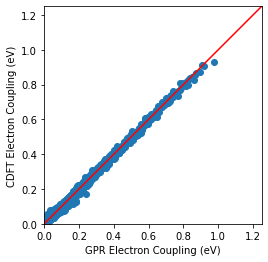

In [81]:
# plotting
x = np.exp(-pred2) * 27.211
y1 = np.exp(-train_chomo_) * 27.211
y2 = train_c_lumo
x0 = [0,1.25]
y0 = [0,1.25]
fig, ax = plt.subplots()
ax.scatter(x,y1)
ax.plot(x0,y0, color='r')
ax.set_xlim(0,1.25)
ax.set_ylim(0,1.25)
ax.set_xlabel('GPR Electron Coupling (eV)')
ax.set_ylabel('CDFT Electron Coupling (eV)')
# ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')